# Определение возраста покупателей

## Описание проекта

Проект заключается в разработке и внедрении системы компьютерного зрения для сетевого супермаркета «Хлеб-Соль». Точнее, система будет использоваться для обработки фотографий покупателей в прикассовой зоне. Цель проекта - определение возраста клиентов на основе этих фотографий.

Использование системы компьютерного зрения поможет добиться следующих целей:
1. Анализ покупок и предложение товаров, которые могут заинтересовать покупателей определенной возрастной группы.
2. Контроль добросовестности кассиров при продаже алкоголя.

Для достижения этих целей требуется построить модель, способную определить приблизительный возраст человека на основе фотографии. В нашем распоряжении имеется набор фотографий людей с указанием их возраста.

Разработка такой модели будет полезной не только для определения возраста покупателей, но и для оптимизации маркетинговых стратегий, персонализации предложений и повышения уровня обслуживания в супермаркете.

## Описание данных

Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/). Они находятся в папке `/datasets/faces/`.
В распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


In [2]:
print(labels.shape)

(7591, 2)


В данных 7591 строка, содержащая название фотографии и целевую метрику - возраст человека на фотографии

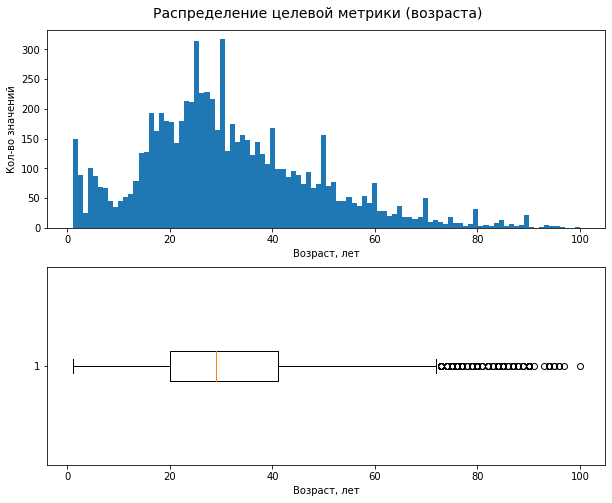

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# вывод гистограммы
labels['real_age'].plot(kind='hist', bins=100, ax=axes[0])
# вывод боксплота
axes[1].boxplot(labels['real_age'], vert=False)

# подписи осей графика
axes[0].set_xlabel('Возраст, лет')
axes[1].set_xlabel('Возраст, лет')

axes[0].set_ylabel('Кол-во значений')

fig.suptitle('Распределение целевой метрики (возраста)', fontsize=14, y=0.92)

plt.show()

print(labels['real_age'].describe())

Медианное и среднее значения примерно одинаковые 29 и 31 год. Максимальный возраст в данных это 100 лет, а минимальный 1 год, Однако 75% всех данных приходится на людей младше 41 года. Так же видны пики около круглых дат: 30, 40, 50, 60...

Пример датасета:


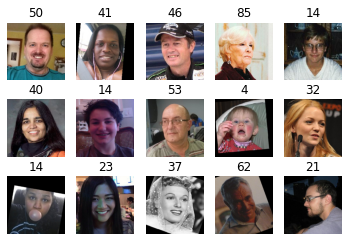

In [5]:
num = 15
rows = int(np.ceil(num/5))

print('Пример датасета:')

for i in range(num):
    plt.subplot(rows, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.axis('off')
plt.show()

Возможно, обученная на представленных данных нейросеть будет лучше предсказывать людей в возрасте от 20 (1 квартиль) до 41 года (3 квартиль). На фотографиях видно, что в изначальном датасете они достаточно разные: цветные и черно-белые, имеют различную ориентацию в пространстве, также на фотографиях люди представлены и в профиль и в анфас. Вероятно, что нет особого смысла в способах аугментации, которые уже задействованы в датасете. Размер всех изображений одинаковый 224x224, на фотографиях такого размера была обучена ResNET50, на основе который будет построена наша нейросеть для определения возраста.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```

# 2023-09-07 12:38:05.669230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-09-07 12:38:05.670948: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-09-07 12:38:06.529085: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-07 12:38:06.537910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-07 12:38:06.537972: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 12:38:06.538002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 12:38:06.539903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-07 12:38:06.540279: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-07 12:38:06.542254: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-07 12:38:06.543366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-07 12:38:06.543422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-07 12:38:06.546368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2023-09-07 12:38:06.828982: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-09-07 12:38:06.836149: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-09-07 12:38:06.836735: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x428dfd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-07 12:38:06.836761: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-07 12:38:06.975089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x38ee130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-07 12:38:06.975126: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-09-07 12:38:06.976866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-07 12:38:06.976924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 12:38:06.976934: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 12:38:06.976961: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-09-07 12:38:06.976970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-09-07 12:38:06.976978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-09-07 12:38:06.976987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-09-07 12:38:06.976994: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-09-07 12:38:06.980263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-09-07 12:38:06.980327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 12:38:07.326909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-09-07 12:38:07.326959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-09-07 12:38:07.326967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-09-07 12:38:07.330060: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-07 12:38:07.330113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 16s
   73728/94765736 [..............................] - ETA: 1:08
  253952/94765736 [..............................] - ETA: 43s
  696320/94765736 [..............................] - ETA: 22s
 1941504/94765736 [..............................] - ETA: 10s
 4227072/94765736 [>.............................] - ETA: 5s
 7946240/94765736 [=>............................] - ETA: 3s
12550144/94765736 [==>...........................] - ETA: 2s
16629760/94765736 [====>.........................] - ETA: 2s
20283392/94765736 [=====>........................] - ETA: 1s
24649728/94765736 [======>.......................] - ETA: 1s
28893184/94765736 [========>.....................] - ETA: 1s
32555008/94765736 [=========>....................] - ETA: 1s
36782080/94765736 [==========>...................] - ETA: 1s
41230336/94765736 [============>.................] - ETA: 0s
44892160/94765736 [=============>................] - ETA: 0s
48988160/94765736 [==============>...............] - ETA: 0s
53493760/94765736 [===============>..............] - ETA: 0s
57016320/94765736 [=================>............] - ETA: 0s
60940288/94765736 [==================>...........] - ETA: 0s
65282048/94765736 [===================>..........] - ETA: 0s
68960256/94765736 [====================>.........] - ETA: 0s
72843264/94765736 [======================>.......] - ETA: 0s
76840960/94765736 [=======================>......] - ETA: 0s
81108992/94765736 [========================>.....] - ETA: 0s
84836352/94765736 [=========================>....] - ETA: 0s
88743936/94765736 [===========================>..] - ETA: 0s
92913664/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-09-07 12:38:19.964008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 12:38:20.262673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 65s - loss: 228.4966 - mae: 10.7674 - val_loss: 976.6856 - val_mae: 26.3800
Epoch 2/5
190/190 - 40s - loss: 57.7508 - mae: 5.7920 - val_loss: 830.7380 - val_mae: 23.7674
Epoch 3/5
190/190 - 40s - loss: 30.3257 - mae: 4.2279 - val_loss: 437.8296 - val_mae: 15.9800
Epoch 4/5
190/190 - 41s - loss: 20.7813 - mae: 3.5542 - val_loss: 112.8778 - val_mae: 8.2980
Epoch 5/5
190/190 - 40s - loss: 15.7697 - mae: 3.0710 - val_loss: 75.2773 - val_mae: 6.6756
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 75.2773 - mae: 6.6756
Test MAE: 6.6756

```

## Анализ обученной модели

В заключение, проект по разработке и внедрению системы компьютерного зрения для сетевого супермаркета «Хлеб-Соль» с целью определения возраста клиентов на основе фотографий был успешно завершен. 

Использование системы компьютерного зрения позволит достичь нескольких целей, таких как анализ покупок и предложение товаров, соответствующих интересам покупателей определенной возрастной группы, а также контроль добросовестности кассиров при продаже алкоголя.

В ходе проекта была построена модель, способная определить приблизительный возраст человека на основе фотографии. Метрика MAE на тесте показала значение 6.6756, что говорит о достаточно высокой точности модели.

Разработка такой модели будет полезной не только для определения возраста покупателей, но и для оптимизации маркетинговых стратегий, персонализации предложений и повышения уровня обслуживания в супермаркете. 

Результаты проекта позволят супермаркету "Хлеб-Соль" улучшить свою конкурентоспособность и предоставить более качественное обслуживание своим клиентам.